In [1]:
file_path = 'https://lstm123.s3.amazonaws.com/filtered_data_mimed0101.csv'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
bucket_name = 'lstm123'
file_path = 'filtered_data_mimed0101.csv'
s3_full_path = f's3://{bucket_name}/{file_path}'

In [6]:
df = pd.read_csv(file_path)

In [7]:
print(df)

       Type  adjusted_time_ints     adjusted_time       Price     Volume
0       ask                 0.0   0 days 00:00:00  258.684211   2.000000
1       ask                 1.0   0 days 00:01:00  254.000000   5.000000
2       ask                 2.0   0 days 00:02:00  258.000000   1.000000
3       ask                 3.0   0 days 00:03:00  259.000000   4.000000
4       ask                 4.0   0 days 00:04:00  261.000000   2.000000
...     ...                 ...               ...         ...        ...
127495  bid             63745.0  44 days 06:25:00  112.000000   1.928571
127496  bid             63746.0  44 days 06:26:00  112.000000   2.600000
127497  bid             63747.0  44 days 06:27:00  113.000000   4.000000
127498  bid             63748.0  44 days 06:28:00  113.000000  10.000000
127499  bid             63749.0  44 days 06:29:00  112.000000   2.625000

[127500 rows x 5 columns]


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [9]:
# Split into asks and bids
df_asks = df[df['Type'] == 'ask'].drop(columns=['Type'])
df_bids = df[df['Type'] == 'bid'].drop(columns=['Type'])

In [10]:
# Normalize the data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))

df_asks['Price'] = scaler_price.fit_transform(df_asks[['Price']])
df_asks['Volume'] = scaler_volume.fit_transform(df_asks[['Volume']])

df_bids['Price'] = scaler_price.transform(df_bids[['Price']])
df_bids['Volume'] = scaler_volume.transform(df_bids[['Volume']])

In [11]:
# We'll need to reset index to align with the transformed data
df_asks.reset_index(drop=True, inplace=True)
df_bids.reset_index(drop=True, inplace=True)
print(df)

       Type  adjusted_time_ints     adjusted_time       Price     Volume
0       ask                 0.0   0 days 00:00:00  258.684211   2.000000
1       ask                 1.0   0 days 00:01:00  254.000000   5.000000
2       ask                 2.0   0 days 00:02:00  258.000000   1.000000
3       ask                 3.0   0 days 00:03:00  259.000000   4.000000
4       ask                 4.0   0 days 00:04:00  261.000000   2.000000
...     ...                 ...               ...         ...        ...
127495  bid             63745.0  44 days 06:25:00  112.000000   1.928571
127496  bid             63746.0  44 days 06:26:00  112.000000   2.600000
127497  bid             63747.0  44 days 06:27:00  113.000000   4.000000
127498  bid             63748.0  44 days 06:28:00  113.000000  10.000000
127499  bid             63749.0  44 days 06:29:00  112.000000   2.625000

[127500 rows x 5 columns]


In [12]:
# Define sequence creation function
def create_sequences(values, time_steps=60):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [13]:
def create_sequences(values, time_steps=60):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [14]:
# Prepare the data for LSTMs
time_steps = 60
X_asks = create_sequences(df_asks[['Price', 'Volume']].values, time_steps)
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)

y_asks = df_asks['Price'][time_steps:].values
y_bids = df_bids['Price'][time_steps:].values

In [15]:
# Train-test split
X_train_asks, X_test_asks, y_train_asks, y_test_asks = train_test_split(X_asks, y_asks, test_size=0.2, random_state=42)
X_train_bids, X_test_bids, y_train_bids, y_test_bids = train_test_split(X_bids, y_bids, test_size=0.2, random_state=42)

In [16]:
# Build the LSTM models
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))  # Output layer: one neuron for predicting the price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [17]:
# Create models for asks and bids
model_asks = create_lstm_model((X_train_asks.shape[1], X_train_asks.shape[2]))
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))


/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))  # Output layer: one neuron for predicting the price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Use the function to create models
# The input shape should be the shape of a single sample (without the batch size)
model_asks = create_lstm_model((X_train_asks.shape[1], X_train_asks.shape[2]))
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))

/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train_asks.shape[1], X_train_asks.shape[2]),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(1))
    
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    return model

In [21]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='lstm_tuning',
    project_name='ask_price_tuning'
)

/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Include the early stopping callback to avoid unnecessary training time
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Execute the hyperparameter search
tuner.search(X_train_asks, y_train_asks,
             epochs=20,
             validation_data=(X_test_asks, y_test_asks),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hp
model = tuner.hypermodel.build(best_hps)
history= model.fit(X_train_asks, y_train_asks, epochs=20, validation_data=(X_test_asks, y_test_asks))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
288               |288               |units
0.0043968         |0.0043968         |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 104/1593 ━━━━━━━━━━━━━━━━━━━━ 4:02 163ms/step - loss: 0.0809

In [57]:
model.save('LSTMmodelAsks.kera')  # Saves the model)

INFO:tensorflow:Assets written to: LSTMmodelAsks.kera/assets


INFO:tensorflow:Assets written to: LSTMmodelAsks.kera/assets


In [28]:
# Save weights
model.save_weights('model_weights_ask.h5')

# Save architecture
model_json = model.to_json()
with open("model_architecture_ask.json", "w") as json_file:
    json_file.write(model_json)


In [29]:
import pickle

with open('trainHistoryDict.pkl', 'wb') as file_pi:  # It's good practice to use .pkl for pickle files
    pickle.dump(history.history, file_pi)


In [30]:
import pickle

# Save with pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [31]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train_asks.shape[1], X_train_asks.shape[2]),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(1))
    
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    return model
# Instantiate the tuner
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='lstm_tuning',
    project_name='bids_price_tuning'
)

Reloading Tuner from lstm_tuning/bids_price_tuning/tuner0.json


In [28]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_bids, y_train_bids,
             epochs=20,
             validation_data=(X_test_bids, y_test_bids),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hp
model = tuner.hypermodel.build(best_hps)
model.fit(X_train_bids, y_train_bids, epochs=20, validation_data=(X_test_bids, y_test_bids))

Trial 30 Complete [00h 01m 40s]
val_loss: 4.799446105607785e-05

Best val_loss So Far: 2.1092431779834442e-05
Total elapsed time: 00h 58m 52s
Epoch 1/20
1593/1593 [==============================] - 27s 15ms/step - loss: 7.0000e-04 - val_loss: 7.6781e-05
Epoch 2/20
1593/1593 [==============================] - 24s 15ms/step - loss: 5.5148e-05 - val_loss: 6.1881e-05
Epoch 3/20
1593/1593 [==============================] - 24s 15ms/step - loss: 5.1549e-05 - val_loss: 6.8344e-05
Epoch 4/20
1593/1593 [==============================] - 24s 15ms/step - loss: 5.1160e-05 - val_loss: 2.7799e-05
Epoch 5/20
1593/1593 [==============================] - 24s 15ms/step - loss: 4.4824e-05 - val_loss: 6.5676e-05
Epoch 6/20
1593/1593 [==============================] - 24s 15ms/step - loss: 4.1937e-05 - val_loss: 4.1473e-05
Epoch 7/20
1593/1593 [==============================] - 24s 15ms/step - loss: 4.0193e-05 - val_loss: 3.7227e-05
Epoch 8/20
1593/1593 [==============================] - 24s 15ms/step - lo

The Hyperband tuner in keras-tuner adjusts the number of trials dynamically based on the max_epochs and the factor parameters. It is not fixed like in a grid search or random search. Instead, Hyperband uses a sports championship style bracketing to run multiple shorter trials and only promotes the top-performing models to the next round.

To determine the number of models that are trained, Hyperband computes the maximum number of brackets (s_max) possible and runs s_max + 1 actual brackets. The number of models in the first bracket is factor^(s_max) * eta^0, where eta is the downscaling factor for each bracket, and this value decreases for each subsequent bracket.

To calculate the actual number of trials that will be executed, you would use the formula from the original Hyperband paper, which is a bit involved, but essentially, it depends on these parameters and the number of hyperband_iterations you specify. The total number of models evaluated will be less than or equal to the product of max_epochs and hyperband_iterations.

Given the parameters in the example provided:

max_epochs=20
factor=3
hyperband_iterations=2 (if this was set, by default it's 1)
The maximum number of brackets s_max is computed internally based on max_epochs and factor. For each bracket, the number of models trained is reduced progressively, so you won't simply have 20 * 2 models trained.

To get the exact number of trials, you could add a line to print tuner.oracle.get_state()['trials'] after the search is completed,

In [32]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),  # Make sure X_train includes both price and volume
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(1))  # Predicting the next price

    # Learning rate is chosen from a logarithmic scale for a more fine-grained search in lower values
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return model



In [56]:
model.save('modelBids.kera')

INFO:tensorflow:Assets written to: modelBids.kera/assets


INFO:tensorflow:Assets written to: modelBids.kera/assets


In [34]:
# Save weights
model.save_weights('model_weights_bids.h5')

# Save architecture
model_json = model.to_json()
with open("model_architecture_bids.json", "w") as json_file:
    json_file.write(model_json)
    import pickle

with open('trainHistoryDict.pkl', 'wb') as file_pi:  # It's good practice to use .pkl for pickle files
    pickle.dump(history.history, file_pi)
    import pickle

# Save with pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming scaler_price is your MinMaxScaler instance for 'Price'
# and you've retained it after scaling your ask data

# If your model is for 'ask' prices
predictions = model.predict(X_test_asks)
predictions_inversed = scaler_price.inverse_transform(predictions)
y_test_asks_inversed = scaler_price.inverse_transform(y_test_asks.reshape(-1, 1))

# Calculate some metrics
mse = mean_squared_error(y_test_asks_inversed, predictions_inversed)
mae = mean_absolute_error(y_test_asks_inversed, predictions_inversed)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

399/399 [==============================] - 2s 3ms/step
Test MSE: 33.70525055474379
Test MAE: 4.979279694052172


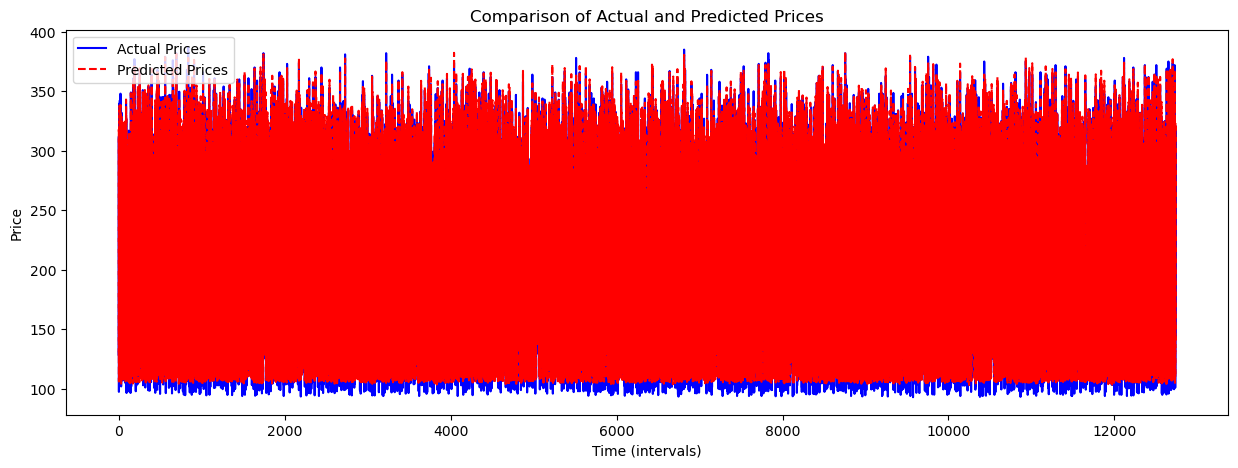

In [36]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test_asks_inversed, label='Actual Prices', color='blue')
plt.plot(predictions_inversed, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time (intervals)')
plt.ylabel('Price')
plt.legend()
plt.show()



In [37]:
look_back = 60

# Extract the timestamps for the test dataset
timestamps_test = df_asks['adjusted_time'][-(len(X_test_asks) + look_back):].reset_index(drop=True)


In [38]:
aligned_timestamps = timestamps_test[look_back:]

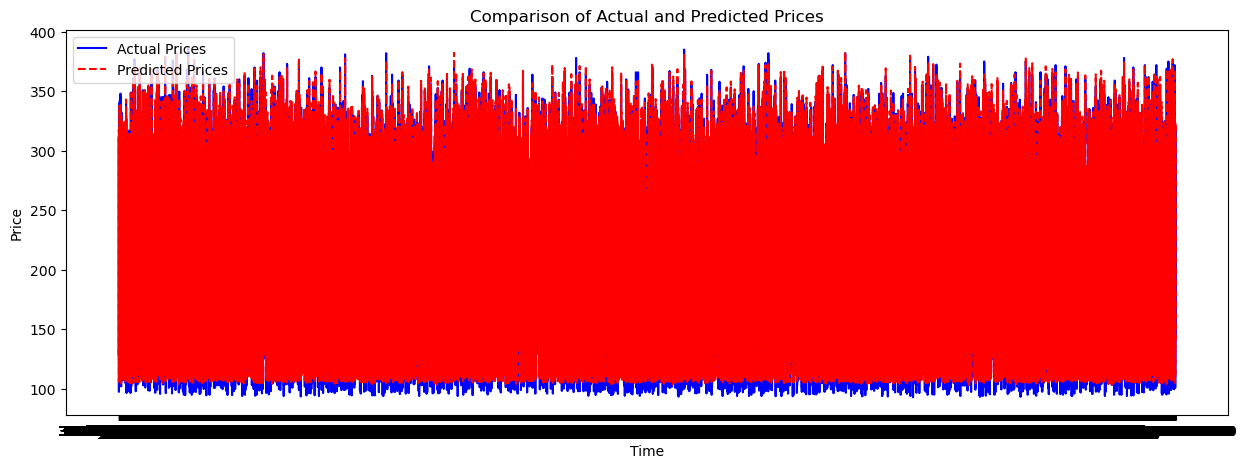

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(aligned_timestamps, y_test_asks_inversed, label='Actual Prices', color='blue')
plt.plot(aligned_timestamps, predictions_inversed, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
# Prepare the data for LSTMs
time_steps = 60
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)
y_bids = df_bids['Price'][time_steps:].values

In [41]:
# Prepare the data for LSTMs
time_steps = 60
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)
y_bids = df_bids['Price'][time_steps:].values

# Train-test split
X_train_bids, X_test_bids, y_train_bids, y_test_bids = train_test_split(X_bids, y_bids, test_size=0.2, random_state=42)

# Create model for bids
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))

In [42]:
model_bids.fit(X_train_bids, y_train_bids, epochs=20, validation_data=(X_test_bids, y_test_bids))

Epoch 1/20
1593/1593 [==============================] - 15s 8ms/step - loss: 9.5719e-04 - val_loss: 1.9255e-04
Epoch 2/20
1593/1593 [==============================] - 11s 7ms/step - loss: 5.4578e-05 - val_loss: 6.6620e-05
Epoch 3/20
1593/1593 [==============================] - 10s 7ms/step - loss: 5.3352e-05 - val_loss: 3.0960e-05
Epoch 4/20
1593/1593 [==============================] - 10s 7ms/step - loss: 4.9097e-05 - val_loss: 3.2257e-05
Epoch 5/20
1593/1593 [==============================] - 10s 7ms/step - loss: 4.2627e-05 - val_loss: 2.8145e-05
Epoch 6/20
1593/1593 [==============================] - 11s 7ms/step - loss: 4.0064e-05 - val_loss: 3.8807e-05
Epoch 7/20
1593/1593 [==============================] - 11s 7ms/step - loss: 3.6901e-05 - val_loss: 2.3629e-05
Epoch 8/20
1593/1593 [==============================] - 11s 7ms/step - loss: 3.7028e-05 - val_loss: 2.2327e-05
Epoch 9/20
1593/1593 [==============================] - 12s 7ms/step - loss: 3.2859e-05 - val_loss: 2.4718e-05
E

In [43]:
# Make predictions for the bid prices
predictions_bids = model_bids.predict(X_test_bids)

399/399 [==============================] - 2s 3ms/step


In [44]:
predictions_bids_inversed = scaler_price.inverse_transform(predictions_bids)
y_test_bids_inversed = scaler_price.inverse_transform(y_test_bids.reshape(-1, 1))

In [45]:
timestamps_test_bids = df_bids['adjusted_time'][len(df_bids) - len(X_test_bids) - time_steps:].reset_index(drop=True)[time_steps:]

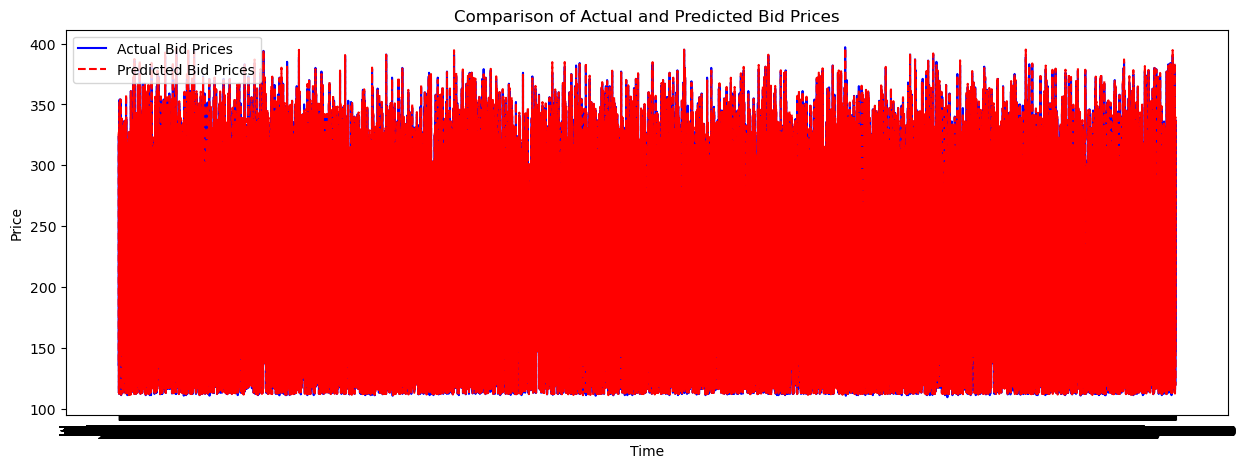

In [46]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps_test_bids, y_test_bids_inversed, label='Actual Bid Prices', color='blue')
plt.plot(timestamps_test_bids, predictions_bids_inversed, label='Predicted Bid Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Bid Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [47]:
# Assuming you've trained your model and named it 'model_asks'
# And 'scaler_price' is the scaler used to normalize the 'Price' column
# Predict ask prices using the test set
predictions_asks = model_asks.predict(X_test_asks)

# Inverse scale the predictions
predictions_asks_inversed = scaler_price.inverse_transform(predictions_asks)

# Ensure you also have the inverse transformed 'y_test_asks' and 'y_test_bids' ready
y_test_asks_inversed = scaler_price.inverse_transform(y_test_asks.reshape(-1, 1))
y_test_bids_inversed = scaler_price.inverse_transform(y_test_bids.reshape(-1, 1))

# Now, you can use predictions_asks_inversed in your trading loop


399/399 [==============================] - 2s 3ms/step


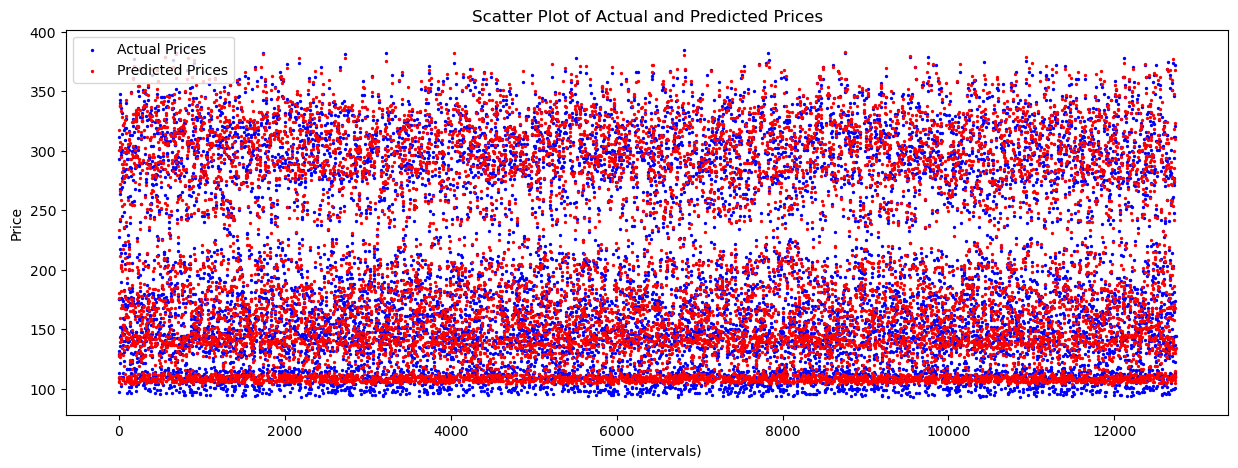

In [49]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test_asks_inversed)), y_test_asks_inversed, color='blue', label='Actual Prices', s=2)
plt.scatter(range(len(predictions_inversed)), predictions_inversed, color='red', label='Predicted Prices', s=2)
plt.title('Scatter Plot of Actual and Predicted Prices')
plt.xlabel('Time (intervals)')
plt.ylabel('Price')
plt.legend()
plt.show()


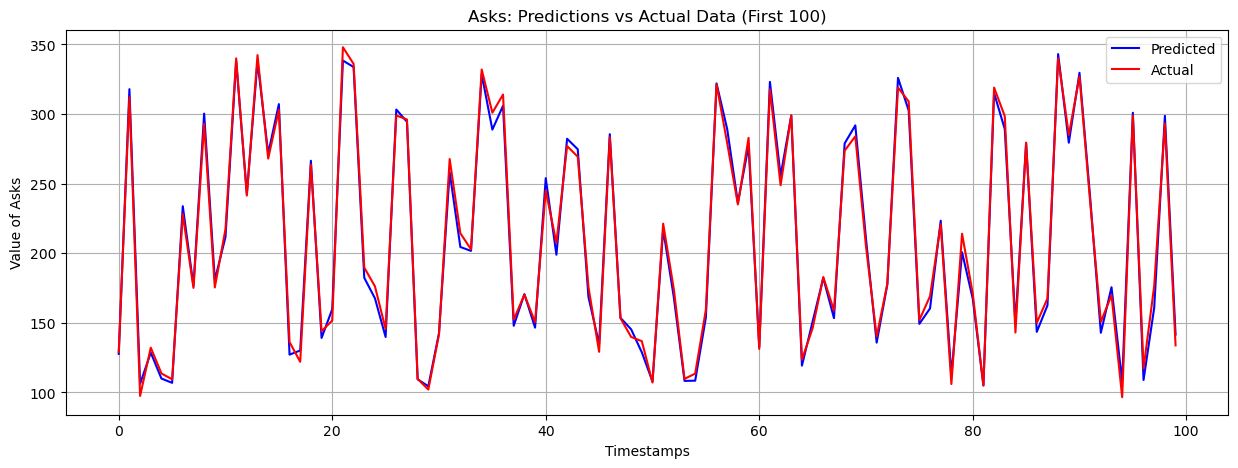

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(predictions_inversed[:100], color= 'blue' , label='Predicted')
plt.plot(y_test_asks_inversed[:100], color='red', label='Actual')
plt.title('Asks: Predictions vs Actual Data (First 100)')
plt.xlabel('Timestamps')
plt.ylabel('Value of Asks')
plt.legend()
plt.grid(True)
plt.show()



In [50]:
s3_full_path = f's3://lstm123/model.h5'

In [52]:
print(df)

       Type  adjusted_time_ints     adjusted_time       Price     Volume
0       ask                 0.0   0 days 00:00:00  258.684211   2.000000
1       ask                 1.0   0 days 00:01:00  254.000000   5.000000
2       ask                 2.0   0 days 00:02:00  258.000000   1.000000
3       ask                 3.0   0 days 00:03:00  259.000000   4.000000
4       ask                 4.0   0 days 00:04:00  261.000000   2.000000
...     ...                 ...               ...         ...        ...
127495  bid             63745.0  44 days 06:25:00  112.000000   1.928571
127496  bid             63746.0  44 days 06:26:00  112.000000   2.600000
127497  bid             63747.0  44 days 06:27:00  113.000000   4.000000
127498  bid             63748.0  44 days 06:28:00  113.000000  10.000000
127499  bid             63749.0  44 days 06:29:00  112.000000   2.625000

[127500 rows x 5 columns]


In [53]:
df.to_csv('my_dataframe.csv', index=False)

In [54]:
from IPython.display import FileLink

display(FileLink('my_dataframe.csv'))

/home/ec2-user/SageMaker/my_dataframe.csv